In [ ]:
# pip install --user --upgrade tensorflow
# https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/train_models_with_tensorFlow_decision_forests.ipynb

from google.cloud import aiplatform
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np

import math
import os

2023-03-11 11:48:39.696040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 11:48:54.524638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-11 11:48:54.546211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [ ]:
print("Aiplatform" + aiplatform.__version__)
print("TensorFlow" + tf.__version__)
print("TensorFlow Decision Forests " + tfdf.__version__)
print("Pandas "+pd.__version__)
print("Numpy "+np.__version__)

Aiplatform1.22.0
TensorFlow2.11.0
TensorFlow Decision Forests 1.2.0
Pandas 1.3.5
Numpy 1.21.6


In [ ]:
# !gsutil cp gs://smart-ml-pongthorn/incident-train-data/TrainEval_Incident.csv data/TrainEval_Incident.csv
dataset_df = pd.read_csv("data/TrainEval_Incident.csv")


label = "severity"

dataset_df=dataset_df.drop(columns=['severity_name'])
dataset_df=dataset_df.rename(columns={'severity_id':'severity'})

classes = dataset_df[label].unique().tolist()

# dataset_df=dataset_df.drop(columns=['severity_id'])
# dataset_df=dataset_df.rename(columns={'severity_name':'severity'})
# dataset_df[label] = dataset_df[label].map(classes.index)


print(f"Label classes: {classes}")

print(dataset_df.info())
dataset_df.head()

Label classes: [4, 2, 3, 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity                   2109 non-null   int64  
 1   sla                        2109 non-null   object 
 2   product_type               2109 non-null   object 
 3   brand                      2109 non-null   object 
 4   service_type               2109 non-null   object 
 5   incident_type              2109 non-null   object 
 6   open_to_close_hour         2109 non-null   float64
 7   response_to_resolved_hour  2109 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 131.9+ KB
None


,severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour
0,4,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,8.050000,7.000000
1,4,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,0.983333,0.583333
2,4,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,9.333333,9.266667
3,4,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,7.000000,7.000000
4,2,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,Hard Disk Drive Failure,23.000000,19.500000


In [ ]:
# Split the dataset into a training and a testing dataset.
def split_dataset(dataset, test_ratio=0.20):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

1693 examples in training, 416 examples for testing.


In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

In [ ]:
# Specify the model.
model_rf = tfdf.keras.RandomForestModel()

# Optionally, add evaluation metrics.
model_rf.compile(
    metrics=["accuracy"])

model_rf.fit(x=train_ds)

Use /tmp/tmpq6rkjoxc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.219697. Found 1693 examples.
Training model...


[INFO 2023-03-11T12:36:22.023566838+00:00 kernel.cc:1214] Loading model from path /tmp/tmpq6rkjoxc/model/ with prefix 8f73c47ae30b472c


Model trained in 0:00:02.682914
Compiling model...


[INFO 2023-03-11T12:36:22.576554026+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 102634 node(s), and 7 input feature(s).
[INFO 2023-03-11T12:36:22.581827144+00:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-11T12:36:22.585732868+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [ ]:
evaluation = model_rf.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 212ms/step - loss: 0.0000e+00 - accuracy: 0.7452
loss: 0.0000
accuracy: 0.7452


In [ ]:
# Save the model
model_rf.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=3)

In [ ]:
model_rf.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	brand
	incident_type
	open_to_close_hour
	product_type
	response_to_resolved_hour
	service_type
	sla

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.              "service_type"  0.517778 ################
    2.                     "brand"  0.295098 ######
    3.             "incident_type"  0.268195 #####
    4.              "product_type"  0.212969 ##
    5.                       "sla"  0.171968 
    6. "response_to_resolved_hour"  0.150829 
    7.        "open_to_close_hour"  0.149569 

Variable Importance: NUM_AS_ROOT:
    1.  "service_type" 175.000000 ################
    2.         "brand" 65.000000 ####

In [ ]:
# The input features
model_rf.make_inspector().features()

["brand" (4; #1),
 "incident_type" (4; #2),
 "open_to_close_hour" (1; #3),
 "product_type" (4; #4),
 "response_to_resolved_hour" (1; #5),
 "service_type" (4; #6),
 "sla" (4; #7)]

In [ ]:
# The feature importances
model_rf.make_inspector().variable_importances()

{'NUM_NODES': [("open_to_close_hour" (1; #3), 18073.0),
  ("response_to_resolved_hour" (1; #5), 15913.0),
  ("incident_type" (4; #2), 6182.0),
  ("brand" (4; #1), 4055.0),
  ("sla" (4; #7), 3734.0),
  ("product_type" (4; #4), 2605.0),
  ("service_type" (4; #6), 605.0)],
 'SUM_SCORE': [("service_type" (4; #6), 123939.78683808818),
  ("open_to_close_hour" (1; #3), 75371.70195500401),
  ("response_to_resolved_hour" (1; #5), 69805.98308826619),
  ("incident_type" (4; #2), 67021.79701839294),
  ("brand" (4; #1), 64313.252995473624),
  ("product_type" (4; #4), 39311.67302406663),
  ("sla" (4; #7), 29750.78086438228)],
 'INV_MEAN_MIN_DEPTH': [("service_type" (4; #6), 0.5177781063981726),
  ("brand" (4; #1), 0.29509839983033054),
  ("incident_type" (4; #2), 0.26819468746061914),
  ("product_type" (4; #4), 0.21296880479827152),
  ("sla" (4; #7), 0.1719679302211018),
  ("response_to_resolved_hour" (1; #5), 0.1508286601788411),
  ("open_to_close_hour" (1; #3), 0.14956869188850008)],
 'NUM_AS_ROOT

# Model Self Evaluation
During training TFDF models can self evaluate even if no validation dataset is provided to the fit() method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation

In [ ]:
model_rf.make_inspector().evaluation()

Evaluation(num_examples=1693, accuracy=0.761370348493798, loss=1.232976917206044, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

# Plotting the training logs

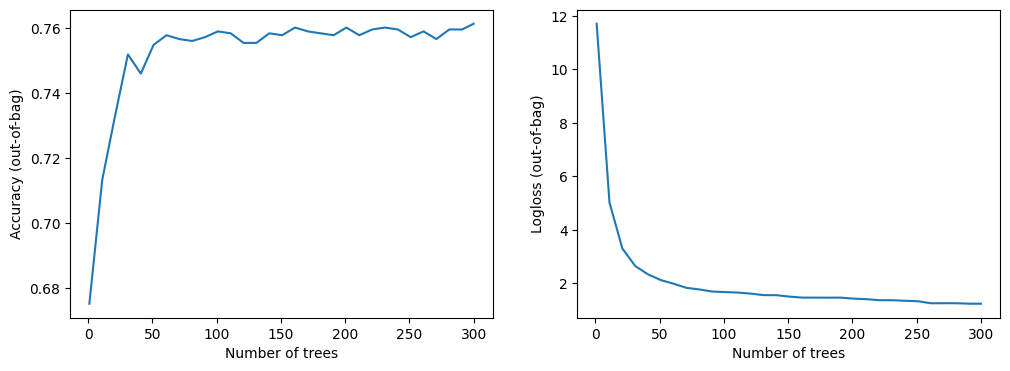

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

logs = model_rf.make_inspector().training_logs()

# Plot the logs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [ ]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [ ]:
# # Clear existing results (if any)
# !rm -fr "/tmp/tensorboard_logs"

# # Export the meta-data to tensorboard.
# model_rf.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

# # docs_infra: no_execute
# # Start a tensorboard instance.
# %tensorboard --logdir "/tmp/tensorboard_logs"

# Re-train the model with a different learning algorithm
The learning algorithm is defined by the model class. For example, tfdf.keras.RandomForestModel() trains a Random Forest, while tfdf.keras.GradientBoostedTreesModel() trains a Gradient Boosted Decision Trees.

The learning algorithms are listed by calling tfdf.keras.get_all_models()

In [ ]:
# List all algorithms
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [ ]:
# # help works anywhere.
# help(tfdf.keras.RandomForestModel)

# # ? only works in ipython or notebooks, it usually opens on a separate panel.
# tfdf.keras.RandomForestModel?

# GradientBoostedTreesModel

In [ ]:
# feature_1 = tfdf.keras.FeatureUsage(name="product_type")
# feature_2 = tfdf.keras.FeatureUsage(name="service_type")
# feature_3 = tfdf.keras.FeatureUsage(name="incident_type")
# selective_features = [feature_1, feature_2,feature_3]
# model_xgb = tfdf.keras.GradientBoostedTreesModel(features=selective_features, exclude_non_specified_features=True)

model_xgb = tfdf.keras.GradientBoostedTreesModel()
model_xgb.compile(metrics=["accuracy"])
model_xgb.fit(x=train_ds, validation_data=test_ds)

print(model_xgb.evaluate(test_ds, return_dict=True))

Use /tmp/tmppez63ey5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.790768. Found 1693 examples.
Reading validation dataset...


Num validation examples: tf.Tensor(416, shape=(), dtype=int32)
Validation dataset read in 0:00:01.452818. Found 416 examples.
Training model...


2023-03-11 13:19:21.085435: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-11 13:19:21.088381: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-11 13:19:21.095790: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-11 13:19:21.114260: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
2023-03-11 13:19:21.117482: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 1693 example(s) and 7 feature(s).
2023-03-11 13:19:2

Model trained in 0:00:01.771281


[INFO 2023-03-11T13:19:22.626969994+00:00 kernel.cc:1214] Loading model from path /tmp/tmppez63ey5/model/ with prefix 7129444fc4044b92
[INFO 2023-03-11T13:19:22.750952515+00:00 decision_forest.cc:661] Model loaded with 105 root(s), 5263 node(s), and 7 input feature(s).
[INFO 2023-03-11T13:19:22.763536407+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2023-03-11T13:19:22.775176765+00:00 kernel.cc:1046] Use fast generic engine


Compiling model...
Model compiled.
1/1 [==============================] - 1s 704ms/step - loss: 0.0000e+00 - accuracy: 0.7620
{'loss': 0.0, 'accuracy': 0.7620192170143127}


# Hyper-parameters
Hyper-parameters are parameters of the training algorithm that impact the quality of the final model. They are specified in the model class constructor. The list of hyper-parameters is visible with the question mark colab command (e.g. ?tfdf.keras.GradientBoostedTreesModel).

In [ ]:
# A classical but slighly more complex model.
model_xgb2 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_xgb2.fit(x=train_ds)

# model_xgb2 = tfdf.keras.GradientBoostedTreesModel(
#     num_trees=500,
#     growing_strategy="BEST_FIRST_GLOBAL",
#     max_depth=8,
#     split_axis="SPARSE_OBLIQUE",
#     categorical_algorithm="RANDOM",
#     )
# model_xgb2.fit(x=train_ds)

Use /tmp/tmp_dooagt7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.221517. Found 1693 examples.
Training model...


2023-03-11 13:20:19.880434: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-11 13:20:19.884561: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-11 13:20:19.885260: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-11 13:20:19.887198: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
2023-03-11 13:20:19.887865: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 1693 example(s) and 7 feature(s).
2023-03-11 13:20:1

Model trained in 0:00:01.119471
Compiling model...


7 input feature(s).
[INFO 2023-03-11T13:20:20.970010932+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2023-03-11T13:20:20.978112679+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [ ]:
model_xgb3 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_xgb3.fit(x=train_ds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpwo_r32bw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.455399. Found 1693 examples.
Training model...


2023-03-11 13:27:51.845325: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-11 13:27:51.851855: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-11 13:27:51.854198: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-11 13:27:51.859425: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
2023-03-11 13:27:51.860077: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 1693 example(s) and 7 feature(s).
2023-03-11 13:27:5

Model trained in 0:00:01.584865
Compiling model...


2023-03-11 13:27:53.316636: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 31
2023-03-11 13:27:53.325961: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 130 tree(s) i.e. 26  iteration(s).
2023-03-11 13:27:53.327269: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:26 valid-loss:0.814694 valid-accuracy:0.716216
[INFO 2023-03-11T13:27:53.356496072+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwo_r32bw/model/ with prefix e63127ea425c4d35
[INFO 2023-03-11T13:27:53.401230804+00:00 decision_forest.cc:661] Model loaded with 130 root(s), 7798 node(s), and 7 input feature(s).
[INFO 2023-03-11T13:27:53.406860474+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2023-03-11T13:27:53.411005061+00:00 kern

Model compiled.


In [ ]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


In [ ]:
# tune model
# dataset = pd.read_csv("project/dataset.csv")
# tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

# tuner = tfdf.tuner.RandomSearch(num_trials=20)
# # Hyper-parameters to optimize.
# tuner.discret("max_depth", [4, 5, 6, 7])

# model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
# model.fit(tf_dataset)